<a href="https://colab.research.google.com/github/takemuralab/F_roboco2025/blob/main/F_roboco2025_lesson2_lecture_balanced_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ロボティクス × 機械学習（Colab対応・SVM/PR/不均衡/学習曲線 拡張 ）



## セクション0：環境セットアップ

Google Colab では、日本語フォントが正しく表示されないことがあります。  
以下のコマンドで **`japanize-matplotlib`** をインストールして、日本語ラベルを正しく描画できるようにします。


In [186]:
!pip install japanize-matplotlib

In [187]:
# ====== 日本語フォント（初回のみ） ======
# ※ 受講者の環境差を吸収するために try/except を入れておく
try:
    import japanize_matplotlib  # 既に入っている場合
except ModuleNotFoundError:
    # Colab では次の行を有効化して実行（ローカル環境なら任意）
    # !pip install japanize-matplotlib
    import sys
    print("⚠️ japanize-matplotlib が見つかりません。日本語ラベルが豆腐になる場合は、上のpip行を有効化して実行してください。", file=sys.stderr)
else:
    import japanize_matplotlib  # 再度明示

# ====== 基本ライブラリ ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== 表示と図のデフォルト設定 ======
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
plt.rcParams["figure.figsize"] = (6.5, 4.2)   # 小さめ・スライド向け
plt.rcParams["figure.dpi"] = 120

# ====== 再現性のための乱数シード（以後一貫して使用） ======
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ====== モデル選択・評価ユーティリティ ======
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,   # cross_validate を使う場合は下で import 追加
    GridSearchCV,
    learning_curve
)
# もしこの後のセクションで cross_validate を使うならこちらも:
# from sklearn.model_selection import cross_validate

# ====== 前処理・パイプライン ======
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ====== 学習アルゴリズム（分類中心／回帰は任意） ======
from sklearn.linear_model import LogisticRegression  # 分類
# 回帰セクションを行う場合のみ利用:
# from sklearn.linear_model import Ridge              # 回帰（L2正則化）

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ====== 評価指標・可視化 ======
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, auc,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    # 回帰セクションを行う場合のみ利用:
    # mean_squared_error, r2_score,
    # クラスタリングの妥当性（クラスタリングセクションで利用）:
    silhouette_score
)

# ====== クラスタリング・次元圧縮（任意の後半セクションで利用） ======
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("Environment ready!  (RANDOM_SEED =", RANDOM_SEED, ")")


Environment ready!  (RANDOM_SEED = 42 )


---
## セクション1：ロボットセンサーデータ（合成・標準シナリオ）

このモデルは「仮想的なロボット運転データ」である。


実際のロボットからセンサログを取ると、これらの変数は相関を持ち、ノイズ分布も非対称になることが多い。


ここでは教育目的で、正規分布・独立性・線形近似を仮定してデータを作成する。
z の係数は物理的直感に基づく重み（強い影響→大きな係数）である。成功確率 p_success はシグモイド関数により 0〜1 に正規化され、それを用いてベルヌーイ試行的に「成功 or 失敗」を生成する。cycle_time は連続値で、将来的には回帰問題に利用できる。これにより「動作成功率」と「生産性（時間）」の2軸分析が可能である。


## 🤖 ロボット動作とロジスティック関数の関係

本データでは「ロボットが1回のピック＆プレース動作に成功する確率」を表現しています。  
センサ値（力・振動・速度・誤差など）から **成功確率 \(p\)** を算出し、その確率で**ベルヌーイ試行**を行います。

---

### 🔹 ロジスティック関数（S字カーブ）の意味

$p = \frac{1}{1 + e^{-z}}$

- \(z\)：動作の「適正スコア」  
  - 把持力や振動、速度などを加重平均した内部指標  
  - \(z>0\)：成功しやすい条件（p→1）  
  - \(z<0\)：失敗しやすい条件（p→0）  
- このS字カーブにより、「連続値z」を確率p（0〜1）に変換します。  

---

| z（条件スコア） | p_success（成功確率） | 状況の例 |
|:--:|:--:|:--:|
| -3 | 0.05 | センサー異常・大きな誤差で失敗しやすい |
| 0  | 0.50 | ちょうど中間（成功/失敗半々） |
| +3 | 0.95 | 最適条件下でほぼ成功 |




## 本ノートのデータ前提（合成データ）
**想定シナリオ：** ロボットアームのピック＆プレース。成功=1 / 失敗=0。  
**特徴量と単位（例）**
- `force_mean` [N]：把持力の平均。高すぎ／低すぎると失敗が増える想定。  
- `force_std` [-]：把持力の変動（安定度）。変動が大きいと失敗が増える。  
- `vib_rms` [-]：エンドエフェクタ付近の振動RMS。大きいと失敗が増える。  
- `imu_ax`, `imu_ay` [g]：IMU加速度（x,y）。姿勢変動の粗い代理。  
- `temp` [°C]：モータ温度。高温化で精度低下→失敗が増える傾向。  
- `speed` [m/s]：ツール先端速度。速すぎ/遅すぎで品質悪化のリスク。  
- `path_error` [mm相当]：軌道追従誤差の大きさ。大きいと失敗が増える。  

**ラベル生成の考え方（合成）**
- ロジスティックモデルで成功確率 $(p=\sigma(z))$ を定義：  
  $z = 0.10(force\_mean-22) - 0.25(force\_std-2.5) - 1.20(vib\_rms-0.5) - 0.35(path\_error-0.3) - 0.03|temp-45| - 0.40|speed-0.6|$  
  → **適正把持力/小さな振動・誤差/適温/適正速度**で成功しやすい。  
- その \(p\) に基づいて**ベルヌーイ試行**で成功(1)/失敗(0)をサンプリング。  
- 参考として回帰ターゲット `cycle_time` もノイズ付きで生成。

**想定されるバイアス**
- 係数の符号・強さは**便宜的に設定**（真のプロセスを完全再現しない）。  
- 特徴量の分布は**独立・正規近似**のため、実データの相関構造とは異なる可能性。  
- 実運用では**センサのスケール、同期ズレ、外乱、設備差**などを考慮して前処理が必要。  
- 本ノートは**手法学習用の近似データ**である点に注意。

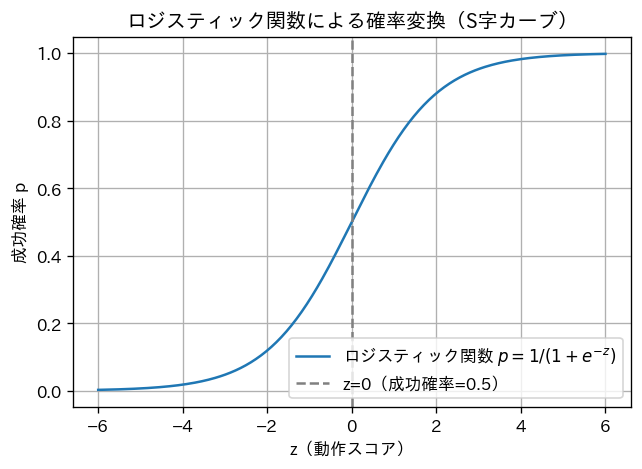

In [188]:
# --- ロジスティック関数（S字カーブ）の可視化 ---
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-6, 6, 300)
p = 1 / (1 + np.exp(-z))

plt.figure(figsize=(6, 4))
plt.plot(z, p, label="ロジスティック関数 $p=1/(1+e^{-z})$")
plt.axvline(0, color="gray", linestyle="--", label="z=0（成功確率=0.5）")
plt.xlabel("z（動作スコア）")
plt.ylabel("成功確率 p")
plt.title("ロジスティック関数による確率変換（S字カーブ）")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [189]:
# ==========================================
# ロボットアームのピック＆プレース動作を想定した合成データ生成
# ==========================================
n_samples = 1200  # 試行サンプル数（=ピック＆プレース動作1200サイクル）

# --- センサ・操作パラメータ群（実際のロボットで測定される想定）---
force_mean = np.random.normal(20, 5, n_samples)       # 把持力[N]：平均20N前後。強すぎ/弱すぎると失敗。
force_std  = np.random.normal(3, 1, n_samples).clip(0.3, None)  # 把持力の標準偏差：小さいほど安定動作。
vib_rms    = np.random.normal(0.6, 0.2, n_samples).clip(0.05, None)  # エンドエフェクタ振動RMS：小さいほど良好。
imu_ax     = np.random.normal(0.0, 0.8, n_samples)    # IMU加速度X軸[g]：姿勢変化や衝撃の代理。
imu_ay     = np.random.normal(0.0, 0.8, n_samples)    # IMU加速度Y軸[g]：姿勢変化や衝撃の代理。
temp       = np.random.normal(45, 6, n_samples).clip(25, 85)     # モータ温度[℃]：高温(>60℃)で精度低下リスク。
speed      = np.random.normal(0.5, 0.15, n_samples).clip(0.1, 1.2)  # ツール先端速度[m/s]：速すぎ/遅すぎで誤動作。
path_error = np.abs(np.random.normal(0.0, 0.8, n_samples))  # 軌道誤差[mm換算]：目標軌道からのズレ。大きいと失敗。

# --- 成功確率モデル ---
# 成功確率をロジスティック関数で定義。
# それぞれの係数は、物理的直感に基づく「成功しやすさ／しにくさ」の重み付け。
z = (
    + 0.10*(force_mean - 22)         # 把持力が22N付近で最適：高すぎても低すぎてもダメ。
    - 0.25*(force_std - 2.5)         # 力のばらつきが大きいと失敗（-）。
    - 1.20*(vib_rms - 0.5)           # 振動が大きいほど失敗（-）。
    - 0.35*(path_error - 0.3)        # 軌道誤差が大きいほど失敗（-）。
    - 0.03*(np.abs(temp - 45))       # 温度が45℃から離れると失敗（±方向とも悪化）。
    - 0.40*(np.abs(speed - 0.6))     # 速度が0.6 m/sから外れると失敗（±方向とも悪化）。
)

# シグモイド関数で成功確率を0〜1に変換
p_success = 1 / (1 + np.exp(-z))

# その確率に従って成功(1)/失敗(0)をサンプリング（ベルヌーイ試行）
y_class = (np.random.rand(n_samples) < p_success).astype(int)

# --- サイクル時間（連続値：秒）---
# 成功／失敗と関係する生産性指標として、1サイクルの作業時間を定義。
# 軌道誤差や振動が大きいほど遅くなり、速度が速いほど短くなる傾向。
cycle_time = (
    3.5                                       # ベースの作業時間[s]
    + 0.8*path_error                          # 軌道誤差が増えると動作が遅れる
    + 0.9*vib_rms                             # 振動が大きいと制御時間が増加
    + 0.02*np.maximum(temp - 45, 0)           # 高温化でモータ性能低下
    - 0.6*speed                               # 高速動作で時間短縮
    + np.random.normal(0, 0.25, n_samples)    # 測定ノイズ
).clip(1.2, None)                             # 下限1.2秒を設定（安全側）

# --- データフレーム化 ---
data = pd.DataFrame({
    "force_mean": force_mean,
    "force_std": force_std,
    "vib_rms": vib_rms,
    "imu_ax": imu_ax,
    "imu_ay": imu_ay,
    "temp": temp,
    "speed": speed,
    "path_error": path_error,
    "success": y_class,
    "cycle_time": cycle_time
})

# 成功率（陽性率）の確認
print("positive rate:", data["success"].mean().round(3))

# 先頭5件を表示
data.head()


positive rate: 0.333


,force_mean,force_std,vib_rms,imu_ax,imu_ay,temp,speed,path_error,success,cycle_time
0,22.483571,3.125225,0.455652,-0.659148,0.405616,38.315512,0.520948,0.187092,0,3.627311
1,19.308678,2.570594,0.635364,-0.575288,-0.045916,41.214415,0.509754,0.931993,0,4.918899
2,23.238443,3.122298,0.490664,1.639850,-1.116359,39.347639,0.621992,0.500255,1,3.506579
3,27.615149,3.543298,0.545669,0.000546,-0.566329,41.712025,0.373422,0.135420,0,3.744943
4,18.829233,3.048860,0.934690,0.625704,-0.210197,43.715098,0.238449,1.081890,0,4.761543



## 🔹 ベルヌーイ試行（Bernoulli trial）とは？

**ベルヌーイ試行**とは、「結果が **成功（1）** または **失敗（0）** のどちらかに分かれる確率的な試行」のことです。  
例：コイン投げで「表」が出るか／ロボットが「物体を正しく掴めるか」。

数学的には：

$
P(Y=1)=p, \quad P(Y=0)=1-p
$

で表され、確率変数 \(Y\) は **ベルヌーイ分布（Bernoulli distribution）** に従います。

---

### 🔸 本ノートでの適用
今回のロボット動作データでは、各サイクル（1試行）をベルヌーイ試行として扱っています。

```python
p_success = 1 / (1 + np.exp(-z))      # 成功確率
y_class = (np.random.rand(n_samples) < p_success).astype(int)  # ベルヌーイ試行
```

- `p_success` : 成功確率（0〜1）
- `np.random.rand()` : 0〜1の一様乱数
- 乱数が `p_success` より小さいと「成功(1)」、大きいと「失敗(0)」

つまり、「成功する確率がp_successのコインをn_samples回投げた」ような確率的試行を行っています。

---

### 🔸 意義と直感
実際のロボット動作では、同じ条件でも環境ノイズ・外乱・微小誤差で結果が変わります。  
そのため「確率的に成功するモデル」で表現する方が現実的です。

- 把持力が最適値付近なら成功確率80%
- 少しずれると50%
- 大きく外れると10%程度 … というように変化します。

---

### 🔸 ロジスティック回帰との関係
ロジスティック回帰の目的関数もベルヌーイ分布に基づいています：

$
L = \prod_i p_i^{y_i}(1-p_i)^{(1-y_i)}
$

これは、**各観測が独立なベルヌーイ試行**であると仮定した尤度関数です。

したがって、ロジスティック回帰＝ベルヌーイ分布の確率モデルを学習する方法です。


---
## セクション2：探索的データ分析（EDA）

モデル化に入る前に、**分布・相関・クラス比**を把握します。


In [190]:
# --- 基本統計と欠損確認 ---
print("データ形状:", data.shape)
print("\n欠損値数:\n", data.isna().sum())
print("\n統計要約:\n", data.describe().round(2))
print("\n成功率 (positive rate):", data["success"].mean().round(3))


データ形状: (1200, 10)

欠損値数:
 force_mean    0
force_std     0
vib_rms       0
imu_ax        0
imu_ay        0
temp          0
speed         0
path_error    0
success       0
cycle_time    0
dtype: int64

統計要約:
        force_mean  force_std  vib_rms   imu_ax   imu_ay     temp    speed  path_error  success  cycle_time
count     1200.00    1200.00  1200.00  1200.00  1200.00  1200.00  1200.00     1200.00  1200.00     1200.00
mean        20.19       3.03     0.60    -0.05    -0.03    44.86     0.50        0.62     0.33        4.28
std          4.94       0.98     0.20     0.79     0.81     6.17     0.16        0.46     0.47        0.49
min          3.79       0.30     0.05    -2.54    -2.32    25.67     0.10        0.00     0.00        2.74
25%         16.87       2.36     0.46    -0.57    -0.55    40.51     0.40        0.25     0.00        3.95
50%         20.24       3.01     0.60    -0.02    -0.03    44.75     0.50        0.52     0.00        4.24
75%         23.38       3.67     0.74     0.

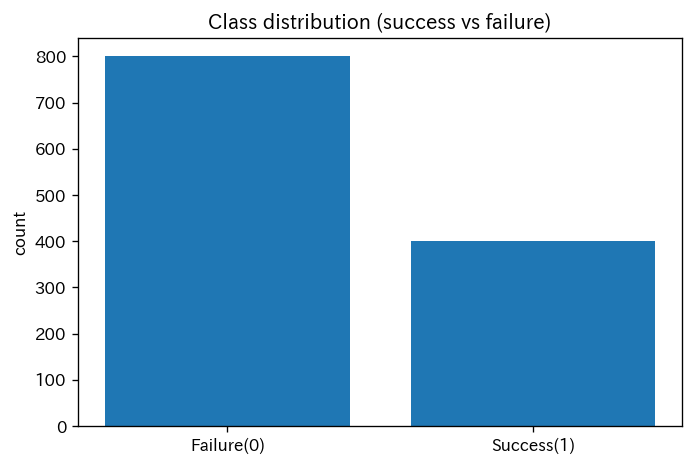

In [191]:
# --- クラス分布（成功/失敗） ---
counts = data["success"].value_counts().sort_index()
plt.figure()
plt.bar(["Failure(0)", "Success(1)"], [counts.get(0,0), counts.get(1,0)])
plt.title("Class distribution (success vs failure)")
plt.ylabel("count")
plt.show()

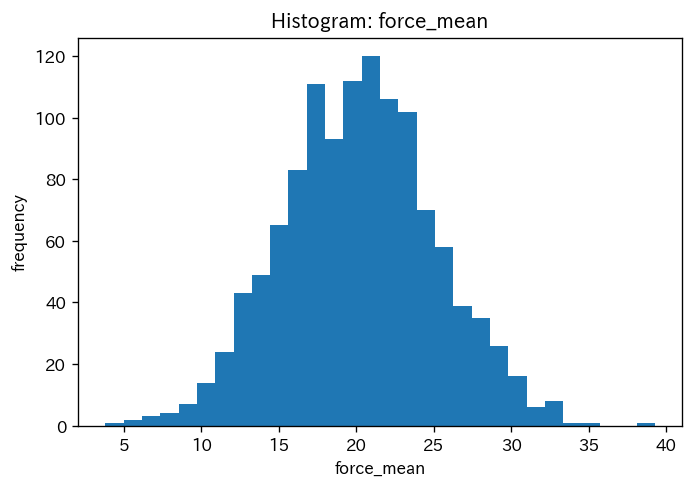

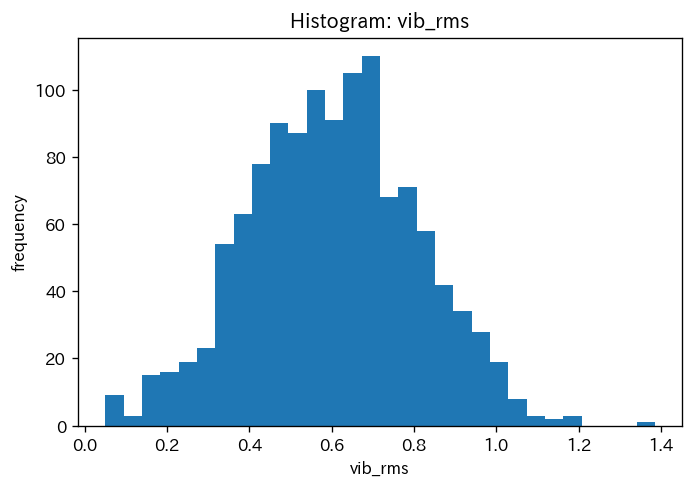

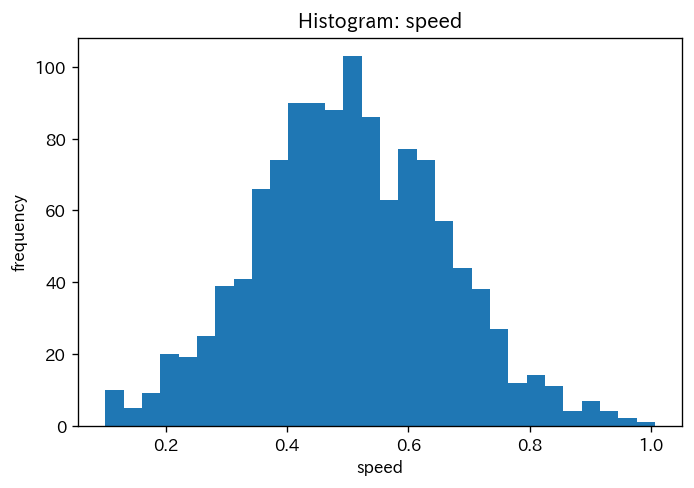

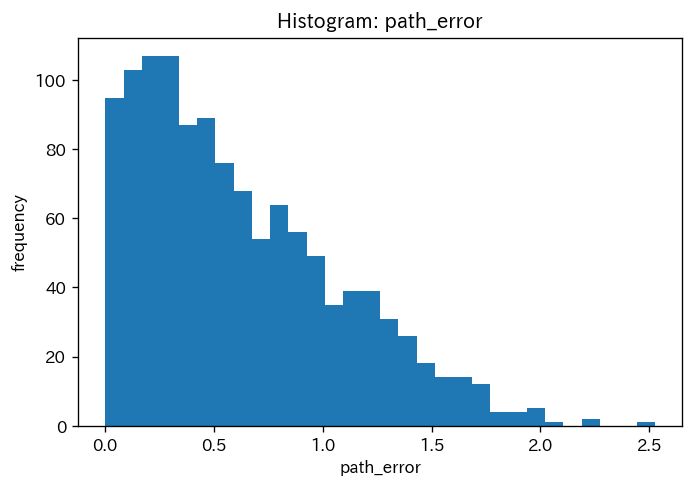

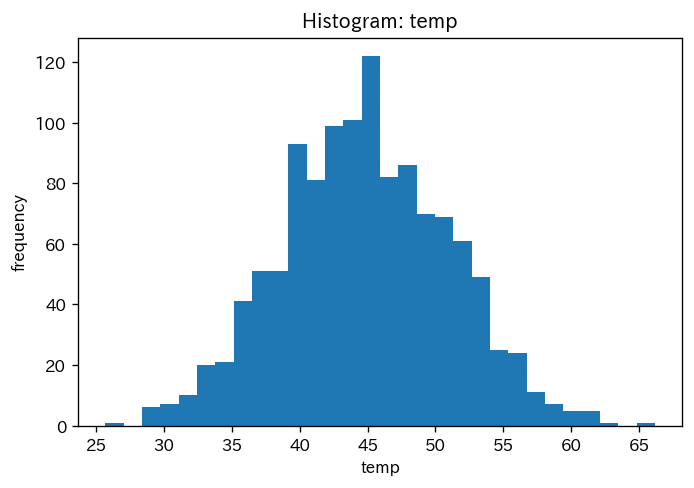

In [192]:
# --- ヒストグラム（主要特徴のみ・1図1系列） ---
for col in ["force_mean", "vib_rms", "speed", "path_error", "temp"]:
    plt.figure()
    plt.hist(data[col].values, bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("frequency")
    plt.show()


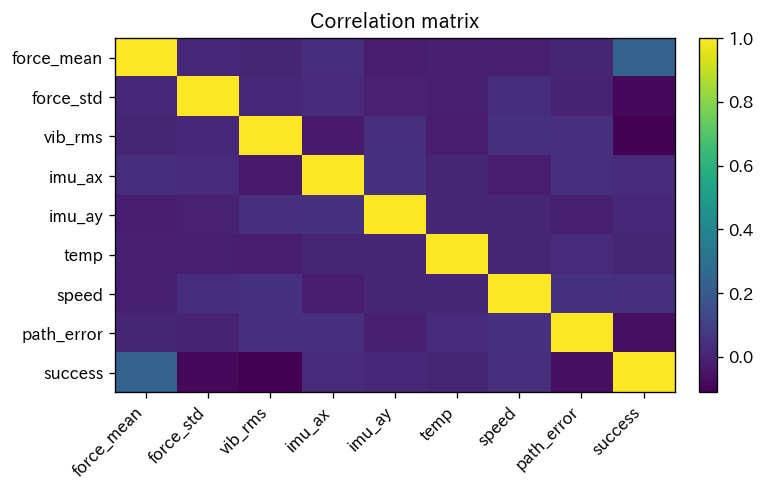

In [193]:
# --- 相関ヒートマップ（matplotlibのみ） ---
cols = ["force_mean","force_std","vib_rms","imu_ax","imu_ay","temp","speed","path_error","success"]
C = data[cols].corr().values
plt.figure()
im = plt.imshow(C, aspect="auto")  # デフォルト色
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


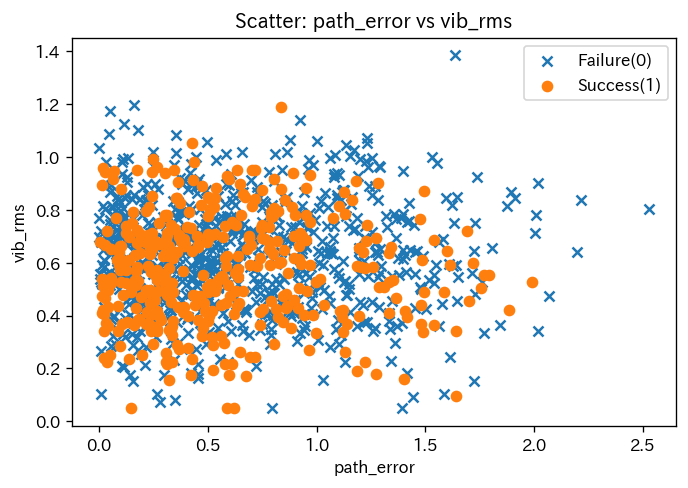

In [194]:
# --- 散布図：path_error vs vib_rms（success別） ---
mask1 = data["success"] == 1
mask0 = ~mask1
plt.figure()
plt.scatter(data.loc[mask0, "path_error"], data.loc[mask0, "vib_rms"], marker="x", label="Failure(0)")
plt.scatter(data.loc[mask1, "path_error"], data.loc[mask1, "vib_rms"], marker="o", label="Success(1)")
plt.xlabel("path_error"); plt.ylabel("vib_rms")
plt.title("Scatter: path_error vs vib_rms")
plt.legend()
plt.show()


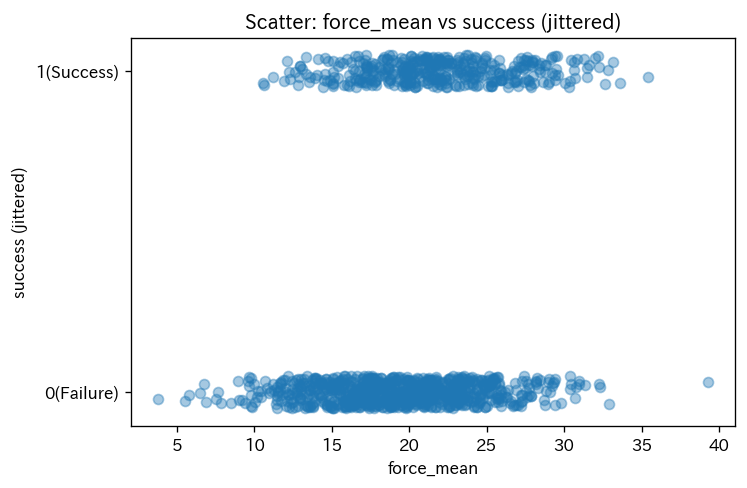

In [195]:

# --- 散布図：force_mean vs success（jittered） ---
y_j = data["success"].values + (np.random.rand(len(data)) - 0.5)*0.1
plt.figure()
plt.scatter(data["force_mean"], y_j, alpha=0.4)
plt.yticks([0,1], ["0(Failure)", "1(Success)"])
plt.xlabel("force_mean"); plt.ylabel("success (jittered)")
plt.title("Scatter: force_mean vs success (jittered)")
plt.show()

## セクション2：教師あり学習（分類）＋ホールドアウト

## 🎓 教師あり学習（Supervised Learning）とは

**教師あり学習**（監督あり学習）では、入力（X）と正解（Y）がペアで与えられ、  
「入力→出力」の関数（モデル）を学習します。

- **分類**：離散ラベルを予測（成功/失敗、不良/良品 など）  
- **回帰**：連続値を予測（サイクル時間、温度 など）

この章では**分類（success: 0/1）**を扱い、**ホールドアウト法**で性能評価を行います。

In [196]:
# ===============================
# 教師あり学習に向けたデータ分割（ホールドアウト法）
# ===============================

# --- 学習に使う特徴量（入力X）を指定 ---
# ロボットのセンサ情報や操作パラメータのうち、
# 成功・失敗を予測するのに有効と思われる変数を選ぶ
features = [
    "force_mean",   # 把持力の平均（安定した力が成功に重要）
    "force_std",    # 把持力のばらつき（ばらつきが大きいと失敗）
    "vib_rms",      # エンドエフェクタの振動（高いと不安定）
    "imu_ax",       # IMU加速度X軸（姿勢変化の指標）
    "imu_ay",       # IMU加速度Y軸（姿勢変化の指標）
    "temp",         # モータ温度（高温では精度低下）
    "speed",        # 動作速度（速すぎても遅すぎても失敗）
    "path_error"    # 軌道誤差（目標軌道からのズレ）
]

# --- 入力データ（X）と出力ラベル（y）の作成 ---
X = data[features].values        # 入力行列：各行が1回の動作（8特徴）
y = data["success"].values       # 出力ベクトル：成功(1)/失敗(0)

# --- ホールドアウト分割 ---
# データを学習用とテスト用に分割して、未知データで性能を評価
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,       # テストデータを全体の25%に設定
    random_state=42,      # 乱数シード固定（再現性確保）
    stratify=y            # 成功/失敗の比率を保って層化分割
)

# --- 結果の確認 ---
print("train:", X_train.shape, " test:", X_test.shape)
print("positive rate (train/test):",
      y_train.mean().round(3), y_test.mean().round(3))


train: (900, 8)  test: (300, 8)
positive rate (train/test): 0.333 0.333


### 2-1) ロジスティック回帰（基準モデル）

[Logistic]
              precision    recall  f1-score   support

           0      0.696     0.940     0.800       200
           1      0.600     0.180     0.277       100

    accuracy                          0.687       300
   macro avg      0.648     0.560     0.538       300
weighted avg      0.664     0.687     0.626       300

正答率 (Accuracy): 0.687
不正答率 (Error rate): 0.313


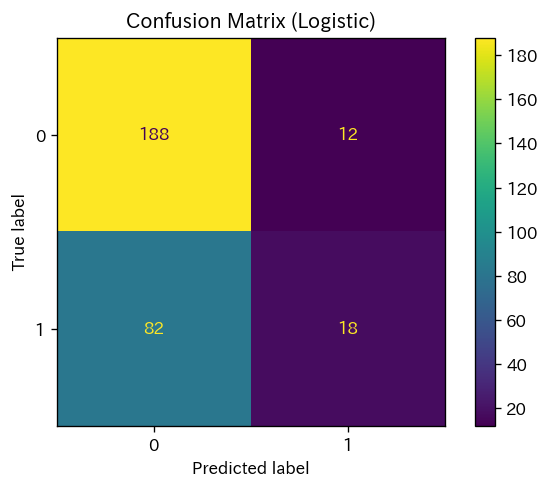

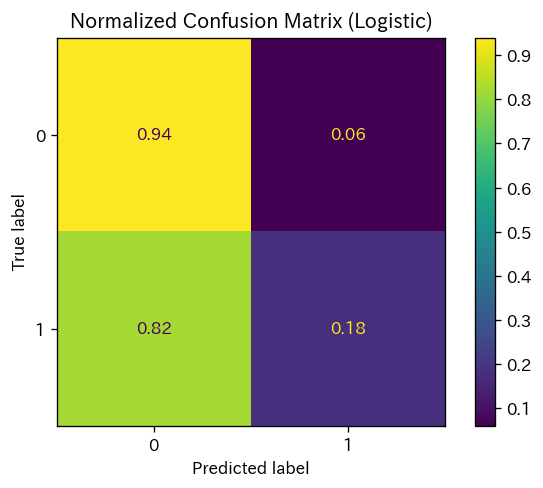

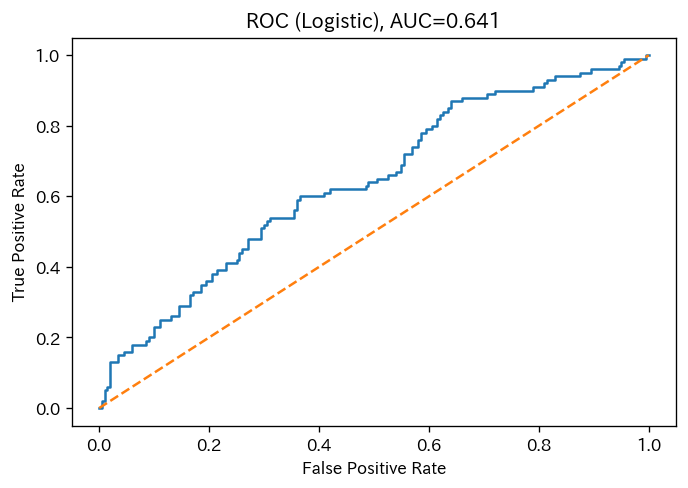

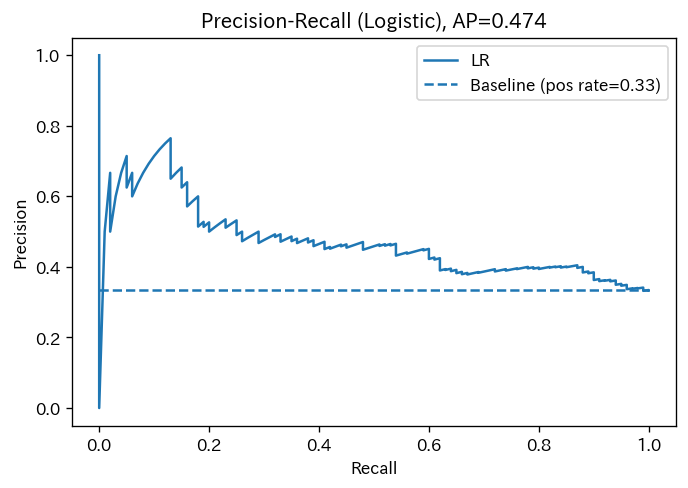

In [197]:
# --- ロジスティック回帰モデルの構築と評価 ---

# パイプラインを構築：
#   1. StandardScaler()：特徴量を標準化（平均0・分散1）
#   2. LogisticRegression()：確率的な分類モデル（max_iterで反復上限を指定）
pipe_lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=200))])

# 学習データでモデルを訓練（fit）
pipe_lr.fit(X_train, y_train)

# テストデータに対して予測を実施
y_pred_lr = pipe_lr.predict(X_test)               # クラス（0 or 1）の予測
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]   # 成功クラス(1)の確率を取得

# --- 分類レポートの出力 ---
# 精度(accuracy)、適合率(precision)、再現率(recall)、F1-score を出力
print("[Logistic]")
print(classification_report(y_test, y_pred_lr, digits=3))

# --- 正答率と不正答率 ---
from sklearn.metrics import accuracy_score
acc_lr = accuracy_score(y_test, y_pred_lr)
err_lr = 1 - acc_lr
print(f"正答率 (Accuracy): {acc_lr:.3f}")
print(f"不正答率 (Error rate): {err_lr:.3f}")

# --- 混同行列（Confusion Matrix）---
# 行：実際のクラス
# 列：予測したクラス
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm_lr).plot()
plt.title("Confusion Matrix (Logistic)")
plt.show()

# --- 正規化混同行列 ---
# 各行（実際のクラス）を1として割合表示に変換
cmn_lr = cm_lr.astype("float") / cm_lr.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cmn_lr).plot(values_format=".2f")
plt.title("Normalized Confusion Matrix (Logistic)")
plt.show()

# --- ROC曲線とAUC ---
# ROC曲線（受信者動作特性曲線）は、閾値を変化させたときの
#   横軸：False Positive Rate（誤検知率）
#   縦軸：True Positive Rate（検出率）
# AUC（Area Under the Curve）は面積。1に近いほど優秀。
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr)
plt.plot([0,1],[0,1], linestyle="--")  # 無作為予測の基準線
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Logistic), AUC={:.3f}".format(auc_lr))
plt.show()

# --- Precision-Recall曲線 ---
# クラス不均衡（成功クラスが少ないなど）の場合に有効な指標。
#   縦軸：Precision（成功と予測した中で正しかった割合）
#   横軸：Recall（成功をどれだけ取りこぼさず予測できたか）
# Average Precision(AP)：PR曲線下の面積
# Baseline：陽性クラス（成功）の事前確率
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
ap_lr = average_precision_score(y_test, y_proba_lr)
baseline = y_test.mean()  # positive rate（陽性率）
plt.figure()
plt.plot(rec_lr, prec_lr, label="LR")
plt.hlines(baseline, xmin=0, xmax=1, linestyles="--",
           label=f"Baseline (pos rate={baseline:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (Logistic), AP={:.3f}".format(ap_lr))
plt.legend()
plt.show()



## 🧩 理論的補足まとめ

| 指標 | 数学的定義 | 意味 | 特徴・使い分け |
|:--|:--|:--|:--|
| **Precision（適合率）** | TP / (TP + FP) | 「成功と予測したうち正しかった割合」 | FP（誤検知）を抑えたい場合に重視 |
| **Recall（再現率）** | TP / (TP + FN) | 「成功したもののうち検出できた割合」 | FN（見逃し）を抑えたい場合に重視 |
| **F1-score** | 2PR / (P+R) | PrecisionとRecallの調和平均 | 両者をバランス良く見たい場合に使用 |
| **ROC-AUC** | ∫TPR dFPR | しきい値全体の性能を表す面積 | クラスバランスが比較的良い場合に適す |
| **AP（平均適合率）** | ∫P dR | PR曲線の面積 | クラス不均衡（陽性が少ない）時に有効 |

---

## 🧠 解釈例（ロボット応用の場合）
- **Precision重視**：誤って「成功」と判定するリスクを避けたい（例：安全系統）  
- **Recall重視**：見逃しを減らしたい（例：異常検知）  
- **F1重視**：全体的な検出精度と信頼性を両立したい（例：工程評価）  
- **AUC/AP重視**：モデルの総合的な判別能力を確認したい（特定しきい値に依存しない）  


### 2-2) SVM（RBFカーネル）

## ⚙️ サポートベクタマシン（SVM：Support Vector Machine）

### 🔹 基本原理
SVMは、**クラスを分ける最も広いマージン（境界間距離）を持つ超平面**を学習する分類モデルです。

- 線形SVMでは、入力特徴空間で「分離境界」を求める。  
- 非線形SVM（カーネルSVM）では、**カーネルトリック**によって  
  データを高次元空間へ写像し、そこで線形分離を行う。

---

### 🔹 RBF（Radial Basis Function）カーネル
RBFカーネルは、距離に基づく類似度を測るカーネル関数です。

$K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$

- 近いサンプルほど類似度が高く、遠いサンプルほど影響が小さくなる。  
- γ（ガンマ）は「どのくらい局所的に影響を持たせるか」を制御するパラメータ。

---


### 🔹 RBF-SVM の利点と特徴
| 特徴 | 内容 |
|:--|:--|
| 表現力 | 線形では分けられない複雑な境界を表現できる |
| カーネルトリック | 高次元空間での線形分離を実現 |
| 正則化パラメータC | 汎化性能と誤分類のトレードオフを調整 |
| γパラメータ | 局所性の強さを制御（小→なだらか, 大→過学習） |

---

### 🔹 本ノートでの目的
- ロボット動作データ（センサ特徴量）をもとに、  
  **RBFカーネルSVM**で「成功／失敗」を分類。  
- ROC曲線やPR曲線を通して、ロジスティック回帰との違いを理解する。


[SVM-RBF]
              precision    recall  f1-score   support

           0      0.691     0.985     0.812       200
           1      0.800     0.120     0.209       100

    accuracy                          0.697       300
   macro avg      0.746     0.552     0.511       300
weighted avg      0.727     0.697     0.611       300

正答率 (Accuracy): 0.697
不正答率 (Error rate): 0.303


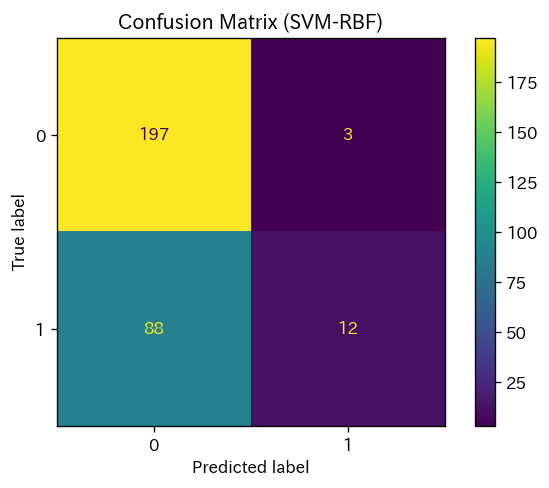

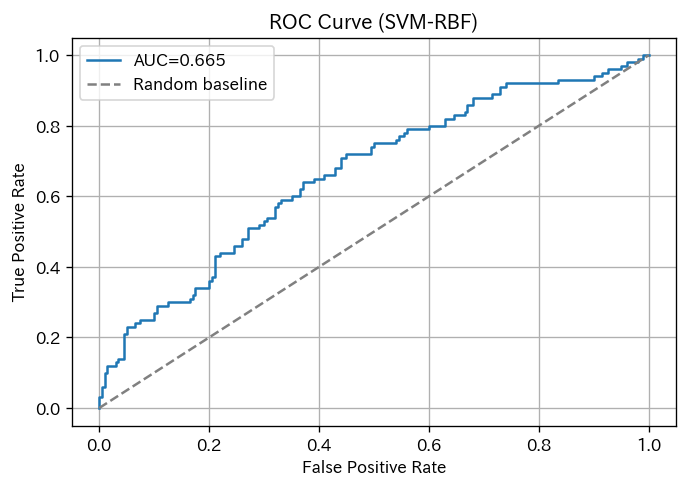

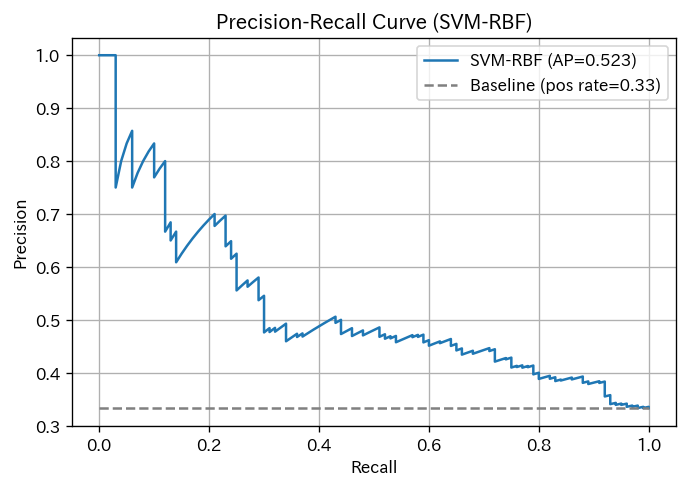

In [198]:
# ==============================================================
# サポートベクタマシン（SVM, RBFカーネル）の分類モデル
# ==============================================================
# RBFカーネルを用いることで、線形では分離できない複雑なパターンも分類可能。
# γ（ガンマ）は「影響範囲の広さ」を制御し、Cは「誤分類の許容度」を制御する。

# --- パイプライン構築 ---
# StandardScaler：SVMは距離ベース手法のため、スケーリングが極めて重要。
# SVC(kernel="rbf")：RBFカーネルを使用。
# probability=True：確率推定（predict_proba）を有効化（内部で交差検証）。
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

# --- 学習 ---
pipe_svm.fit(X_train, y_train)

# --- 予測 ---
y_pred_svm = pipe_svm.predict(X_test)             # 0/1分類結果
y_proba_svm = pipe_svm.predict_proba(X_test)[:,1] # 成功クラス(1)の確率

# ==============================================================
# 評価①：分類レポート
# ==============================================================
print("[SVM-RBF]")
print(classification_report(y_test, y_pred_svm, digits=3))

# --- 正答率と不正答率 ---
from sklearn.metrics import accuracy_score
acc_lr = accuracy_score(y_test, y_pred_svm)
err_lr = 1 - acc_lr
print(f"正答率 (Accuracy): {acc_lr:.3f}")
print(f"不正答率 (Error rate): {err_lr:.3f}")

# ==============================================================
# 評価②：混同行列（Confusion Matrix）
# ==============================================================
# SVMがどのクラスを間違えやすいかを可視化。
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot()
plt.title("Confusion Matrix (SVM-RBF)")
plt.show()

# ==============================================================
# 評価③：ROC曲線とAUC
# ==============================================================
# ROC曲線は、モデルのしきい値を変えたときの
# 感度（TPR）と誤検知率（FPR）のトレードオフを表す。
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"AUC={auc_svm:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM-RBF)")
plt.legend()
plt.grid(True)
plt.show()

# ==============================================================
# 評価④：Precision-Recall曲線とAP
# ==============================================================
# Precision（予測の正確さ）とRecall（見逃しの少なさ）の関係を表示。
# AP（Average Precision）はPR曲線下の面積。高いほど性能良好。
prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_proba_svm)
ap_svm = average_precision_score(y_test, y_proba_svm)
baseline = y_test.mean()  # 陽性率（成功クラスの比率）

plt.figure()
plt.plot(rec_svm, prec_svm, label=f"SVM-RBF (AP={ap_svm:.3f})")
plt.hlines(baseline, xmin=0, xmax=1, linestyles="--", color="gray",
           label=f"Baseline (pos rate={baseline:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (SVM-RBF)")
plt.legend()
plt.grid(True)
plt.show()


### 2-3) ROC/PRのモデル間比較（ベースライン付）

## 📈 ROC曲線・PR曲線・AUC・AP の基礎理論

機械学習の分類問題では、**モデルの出力確率（スコア）**をどの閾値で「1（成功）」と判定するかにより、  
精度や再現率が変化します。  
この「しきい値を動かしたときの挙動」を可視化するのが **ROC曲線** と **PR曲線** です。

---

### 🔹 ROC曲線（Receiver Operating Characteristic Curve）

ROC曲線は、モデルの**全体的な判別能力**を評価するための指標です。  
しきい値を0〜1で変化させたときの「感度（再現率）」と「誤検知率（偽陽性率）」の関係を表します。

\[
\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN}
\]
\[
\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}
\]

- **横軸：** False Positive Rate（誤検知率）  
- **縦軸：** True Positive Rate（検出率）  
- **理想的なモデル：** 左上（TPR=1, FPR=0）に近いほど優秀  

#### 🧩 AUC（Area Under the Curve）
ROC曲線の下の面積（Area Under Curve）を数値化したものです。  
- AUC = 1.0 → 完璧な分類  
- AUC = 0.5 → ランダム分類（性能なし）  
- AUCが大きいほど、しきい値に依存しない**総合的な判別性能**が高い

---

### 🔹 Precision-Recall（PR）曲線

PR曲線は、**クラス不均衡**（陽性例が少ない）場合に有効な性能評価指標です。

$
\text{Precision} = \frac{TP}{TP + FP}, \quad
\text{Recall} = \frac{TP}{TP + FN}
$

- **横軸：** Recall（再現率）＝成功をどれだけ検出できたか  
- **縦軸：** Precision（適合率）＝予測した成功のうち正しかった割合  
- **Baseline：** 陽性クラス（成功）の事前確率（pos rate）を基準線として比較  

PR曲線の形状でモデルの**実用的な性能（false positiveに強いか）**を判断できます。

#### 🧩 AP（Average Precision）
PR曲線の下の面積に相当し、PrecisionをRecallにわたって積分した指標です。  
AUCに対応する概念で、「高Precisionを広いRecall範囲で維持できるほど高値」となります。

---

### 🔹 ROCとPRの使い分け
| 比較項目 | ROC曲線 | PR曲線 |
|:--|:--|:--|
| 評価対象 | モデル全体の識別能力 | 陽性クラス（成功）の検出能力 |
| 有効なケース | クラス分布がバランスしている場合 | 成功クラスが少ない場合（不均衡データ） |
| 指標 | AUC | AP（平均適合率） |
| 理解の視点 | 「どの程度うまく分離できるか」 | 「誤警報を抑えて成功を拾えるか」 |

---

### 🔹 直感的な理解
- **ROC曲線** → 「モデルがどれだけ正しく分けられるか（分類器の判別力）」  
- **PR曲線** → 「成功クラスをどれだけ効率よく拾えるか（実用性能）」  

📊 つまり：
- ROC：モデルのポテンシャル全体を評価  
- PR：実際の現場での有効性を評価（特に成功率が低い場合）

---

### 💡 ロボット応用の例
| 指標 | ロボットタスクでの意味 | 改善アプローチ |
|:--|:--|:--|
| **TPR（Recall）** | 成功動作を取りこぼさない | センサ特徴を増やす、閾値を下げる |
| **FPR** | 誤って成功と判定（危険動作） | 閾値を上げる、異常値除去 |
| **Precision** | 成功と予測した中で本当に成功 | 学習データの精度向上 |
| **AUC/AP** | モデル全体の信頼度 | 特徴量選択・ハイパーパラメータ調整 |

---

🧠 **まとめ**
- **ROC曲線＋AUC**：分類器の総合的な判別能力  
- **PR曲線＋AP**：クラス不均衡下での実運用精度  
- **現場評価では、AUCとAPを両方見る**ことで、モデルの「理論性能」と「実効性能」をバランスよく判断できる。


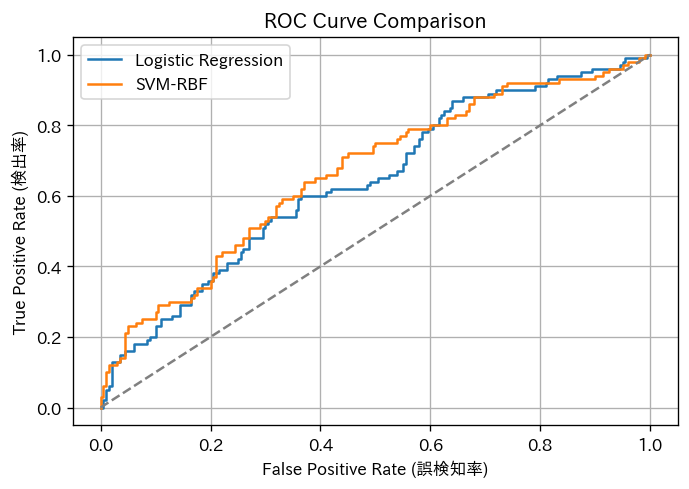

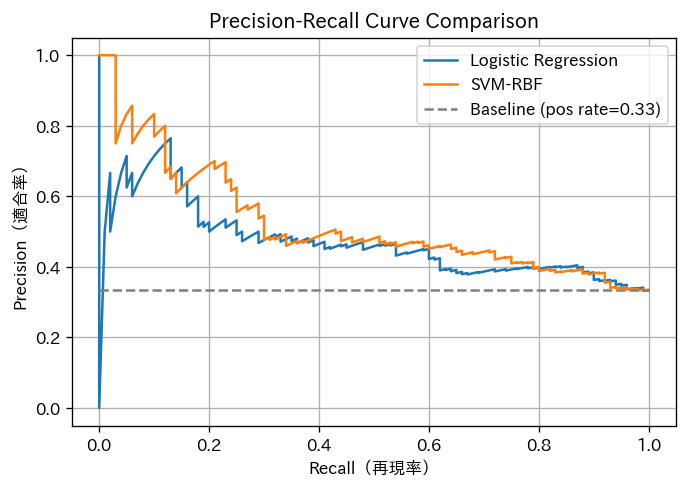

In [199]:
# ==============================================================
# ROC曲線の比較（ロジスティック回帰 vs SVM-RBF）
# ==============================================================
# 目的：異なる分類モデルの「全体的な判別能力（AUC）」を比較する。
# - ROC曲線：しきい値を動かしたときの感度（TPR）と誤検知率（FPR）の関係
# - 左上に近いほど性能が高い
plt.figure()
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")  # ロジスティック回帰のROC
plt.plot(fpr_svm, tpr_svm, label="SVM-RBF")            # SVMのROC
plt.plot([0,1],[0,1], linestyle="--", color="gray")    # ランダム分類の基準線
plt.xlabel("False Positive Rate (誤検知率)")
plt.ylabel("True Positive Rate (検出率)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()



# ==============================================================
# Precision-Recall（PR）曲線の比較
# ==============================================================
# 目的：クラス不均衡（成功クラスが少ないなど）の下での検出性能を比較する。
# - 縦軸 Precision：予測した成功の中で実際に成功だった割合
# - 横軸 Recall：実際の成功をどれだけ正しく検出できたか
# - Baseline：陽性クラス（成功）の事前確率（pos rate）
baseline = y_test.mean()
plt.figure()
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_svm, prec_svm, label="SVM-RBF")
plt.hlines(baseline, xmin=0, xmax=1, linestyles="--", color="gray",
           label=f"Baseline (pos rate={baseline:.2f})")
plt.xlabel("Recall（再現率）")
plt.ylabel("Precision（適合率）")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


---
## セクション4：ハイパーパラメータチューニング（SVM / RF）

## 🔧 ハイパーパラメータチューニング（GridSearchCV）

### 🔹 目的
- 学習で最適化されるのは「**モデルのパラメータ**」（例：ロジスティック回帰の重み、SVMのサポートベクタなど）。
- 一方、モデルの挙動を規定する「**ハイパーパラメータ**」（例：SVMの C・γ、RandomForest の木の数・深さ）は学習では決まらないため、**探索**が必要。
- 代表的手法：**GridSearchCV**（グリッド探索）や RandomizedSearchCV（ランダム探索）

### 🔹 Cross-Validation（交差検証）とスコア
- `cv=k` で学習データを k 分割し、**学習→検証**を k 回繰り返して汎化性能を推定。
- スコアはタスクに応じて設定：不均衡なら **F1**・**PR-AUC(AP)**、バランス型なら **ROC-AUC**・**Accuracy** など。

### 🔹 SVM（RBF）の主要ハイパラ
- **C**：誤分類をどこまで許すか（大きいほど訓練誤差に厳しく、過学習傾向）
- **γ（gamma）**：RBFの局所性（大きいほど境界が細かく、過学習傾向）
- **probability=True**：確率出力を有効化（内部で追加のCV計算が走る）

### 🔹 RandomForest の主要ハイパラ
- **n_estimators**：決定木の本数（多いほど安定だが重くなる）
- **max_depth**：木の深さ（None は無制限。深いと過学習傾向）
- **min_samples_split**：ノード分割に必要な最小サンプル数（大きくすると汎化寄り）
- **max_features**：分割時に検討する特徴数（`"sqrt"` がよく使われる）

### 🔹 Pipeline を使う理由（データリーク対策）
- **前処理（標準化）→ 学習器**を一体化してCV内で実行することで、**訓練 fold のみ**で標準化を学習し、**検証 fold**へ漏れないようにする。
- ※RFはスケール非依存だが、統一のためパイプラインに入れても問題なし。

### 🔹 注意点
- チューニングに **テストデータを絶対に使わない**。テストは最後の一回のみ。
- 最終評価は **best_estimator_** を **テストデータ** に適用。
- 重要案件では **ネストCV**（外側CVで汎化性能推定、内側CVでチューニング）を検討。



In [200]:
# ==============================================================
# ハイパーパラメータチューニング（SVM & RandomForest）
# ==============================================================
# GridSearchCV を用いて、各モデルのパフォーマンスを最大化する
# ハイパーパラメータ（モデル挙動を制御する設定値）を探索します。
# 評価指標には F1-score を採用（Precision と Recall のバランス重視）

from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score)  # F1スコアを最適化指標として設定

# ==============================================================
# 1. SVM（RBFカーネル）のハイパーパラメータ探索
# ==============================================================
# SVMの主なパラメータ：
#   - C: 誤分類をどこまで許すか（大きいと過学習しやすい）
#   - gamma: RBFカーネルの局所性（大きいと境界が複雑になり過学習）
# 目的：F1スコアを最大化するCとγを見つける。

grid_svm = GridSearchCV(
    # SVMモデルを標準化込みでパイプライン化（データリーク防止）
    Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=42))
    ]),
    # グリッド探索範囲を指定
    param_grid={
        "clf__C": [0.5, 1, 3, 10],            # モデルの正則化強度
        "clf__gamma": ["scale", 0.05, 0.1, 0.2]  # カーネル幅（小さいと滑らか）
    },
    cv=3,                  # 3分割交差検証（3-fold CV）
    scoring=f1_scorer,     # 評価指標にF1スコアを使用
    n_jobs=-1              # CPU全コアを使用（並列計算）
)

# --- モデル学習とチューニング実行 ---
grid_svm.fit(X_train, y_train)

# 最良パラメータとCV平均スコアを出力
print("Best SVM params:", grid_svm.best_params_, "  CV F1:", grid_svm.best_score_)

# --- 最良モデル（best_estimator_）でテストデータを評価 ---
best_svm = grid_svm.best_estimator_  # チューニング済み最良モデルを抽出
y_pred_best_svm = best_svm.predict(X_test)               # クラス予測
y_proba_best_svm = best_svm.predict_proba(X_test)[:, 1]  # 成功クラス(1)の確率予測

# テストデータ上での性能を出力（Precision, Recall, F1, Support）
print("\n[SVM-RBF tuned on Test]")
print(classification_report(y_test, y_pred_best_svm, digits=3))

# ==============================================================
# 2. RandomForest のハイパーパラメータ探索
# ==============================================================
# RandomForestの主なパラメータ：
#   - n_estimators: 木の本数（多いほど安定だが計算が重い）
#   - max_depth: 木の深さ（Noneは制限なし、深いと過学習）
#   - min_samples_split: ノード分割に必要な最小サンプル数（大きくすると汎化寄り）
#   - max_features: 分割時に考慮する特徴数（"sqrt"が標準的）
# 目的：F1スコアを最大化する構成を探索する。

grid_rf = GridSearchCV(
    # RFもPipeline化して統一的に扱う（scalerは不要だが構文統一）
    Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    # 探索範囲
    param_grid={
        "clf__n_estimators": [100, 300],        # 決定木の数
        "clf__max_depth": [None, 6, 12],        # 木の深さ（None=制限なし）
        "clf__min_samples_split": [2, 5],       # ノード分割の最小サンプル
        "clf__max_features": ["sqrt", None]     # 分割時に使用する特徴数
    },
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1
)

# --- モデル学習とチューニング実行 ---
grid_rf.fit(X_train, y_train)

# 最良パラメータとCV平均スコアを出力
print("Best RF params:", grid_rf.best_params_, "  CV F1:", grid_rf.best_score_)

# --- 最良モデルでテストデータを評価 ---
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n[RF tuned on Test]")
print(classification_report(y_test, y_pred_best_rf, digits=3))


Best SVM params: {'clf__C': 10, 'clf__gamma': 0.1}   CV F1: 0.26210713247256323

[SVM-RBF tuned on Test]
              precision    recall  f1-score   support

           0      0.695     0.925     0.794       200
           1      0.559     0.190     0.284       100

    accuracy                          0.680       300
   macro avg      0.627     0.557     0.539       300
weighted avg      0.650     0.680     0.624       300

Best RF params: {'clf__max_depth': 12, 'clf__max_features': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}   CV F1: 0.31908597731382543

[RF tuned on Test]
              precision    recall  f1-score   support

           0      0.695     0.900     0.784       200
           1      0.512     0.210     0.298       100

    accuracy                          0.670       300
   macro avg      0.604     0.555     0.541       300
weighted avg      0.634     0.670     0.622       300



### 4-1) ROC/PR（チューニング後モデル・ベースライン付）

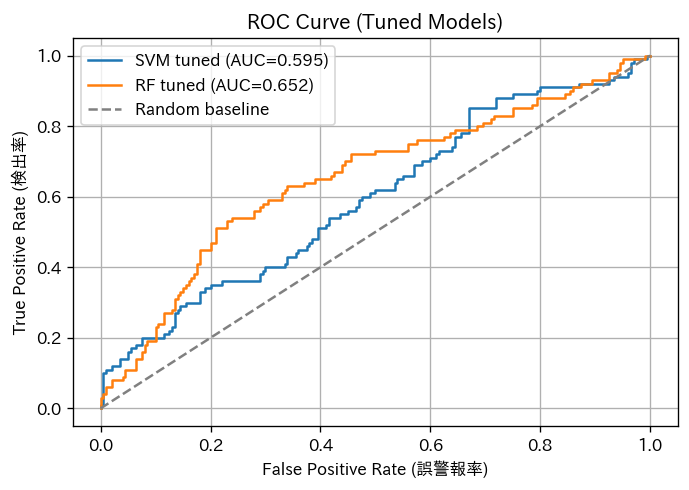

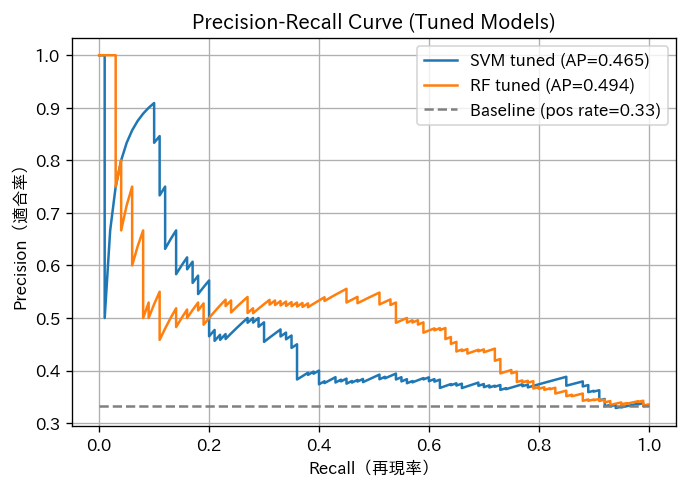

In [201]:
# ==============================================================
# ROC曲線・PR曲線によるチューニング後モデルの性能比較
# ==============================================================
# 対象モデル：
#   - best_svm : GridSearchCV で最適化された SVM（RBF）
#   - best_rf  : GridSearchCV で最適化された RandomForest
# 目的：
#   - ROC曲線（AUC）と PR曲線（AP）により、2つのモデルの判別性能を可視化・比較する
#   - 特にSVMは非線形モデル、RFはアンサンブルモデルとしての特徴があるため、
#     それぞれの長所を理解することが重要。

# ==============================================================
# ROC曲線（Receiver Operating Characteristic）
# ==============================================================
# 横軸：False Positive Rate（誤警報率 = FP / (FP + TN)）
# 縦軸：True Positive Rate（検出率 = TP / (TP + FN)）
# AUC（曲線下の面積）でモデルの判別力を定量化（1に近いほど良い）

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# --- ROC座標の計算 ---
fpr_tsvm, tpr_tsvm, _ = roc_curve(y_test, y_proba_best_svm)   # SVMチューニング後
fpr_trf,  tpr_trf,  _ = roc_curve(y_test, y_proba_best_rf)    # RFチューニング後

# --- AUC（面積）の計算 ---
auc_tsvm = auc(fpr_tsvm, tpr_tsvm)
auc_trf  = auc(fpr_trf,  tpr_trf)

# --- プロット（ROC）---
plt.figure()
plt.plot(fpr_tsvm, tpr_tsvm, label=f"SVM tuned (AUC={auc_tsvm:.3f})")
plt.plot(fpr_trf,  tpr_trf,  label=f"RF tuned (AUC={auc_trf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random baseline")
plt.xlabel("False Positive Rate (誤警報率)")
plt.ylabel("True Positive Rate (検出率)")
plt.title("ROC Curve (Tuned Models)")
plt.legend()
plt.grid(True)
plt.show()

# ==============================================================
# PR曲線（Precision-Recall Curve）
# ==============================================================
# 横軸：Recall（再現率 = TP / (TP + FN)）
# 縦軸：Precision（適合率 = TP / (TP + FP)）
# クラス不均衡な場合、ROCよりPR曲線の方が有効。
# AP（Average Precision）はPR曲線下の面積を意味し、
# 高Precisionを広いRecall範囲で維持できるモデルほど高スコア。

# --- PR座標とAP値の計算 ---
prec_tsvm, rec_tsvm, _ = precision_recall_curve(y_test, y_proba_best_svm)
prec_trf,  rec_trf,  _ = precision_recall_curve(y_test, y_proba_best_rf)
ap_tsvm = average_precision_score(y_test, y_proba_best_svm)
ap_trf  = average_precision_score(y_test, y_proba_best_rf)

# --- 陽性クラス（成功）の基準線 ---
baseline = y_test.mean()  # データ中の成功率（正例率）

# --- プロット（PR）---
plt.figure()
plt.plot(rec_tsvm, prec_tsvm, label=f"SVM tuned (AP={ap_tsvm:.3f})")
plt.plot(rec_trf,  prec_trf,  label=f"RF tuned (AP={ap_trf:.3f})")
plt.hlines(baseline, xmin=0, xmax=1, linestyles="--", color="gray",
           label=f"Baseline (pos rate={baseline:.2f})")
plt.xlabel("Recall（再現率）")
plt.ylabel("Precision（適合率）")
plt.title("Precision-Recall Curve (Tuned Models)")
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix (SVM tuned):
[[185  15]
 [ 81  19]]


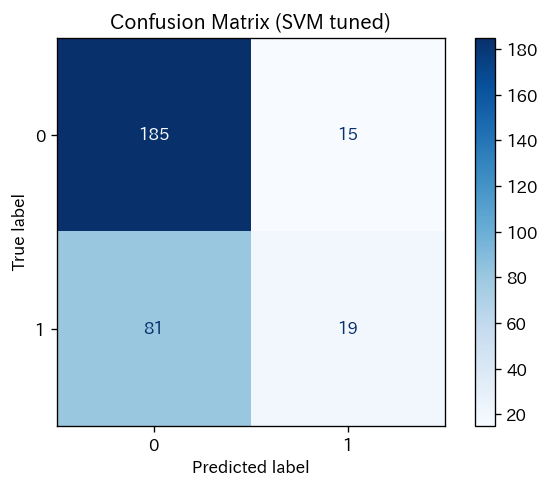

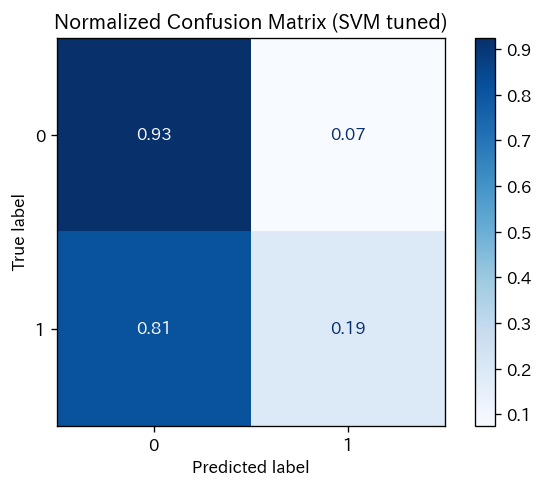


Confusion Matrix (RF tuned):
[[180  20]
 [ 79  21]]


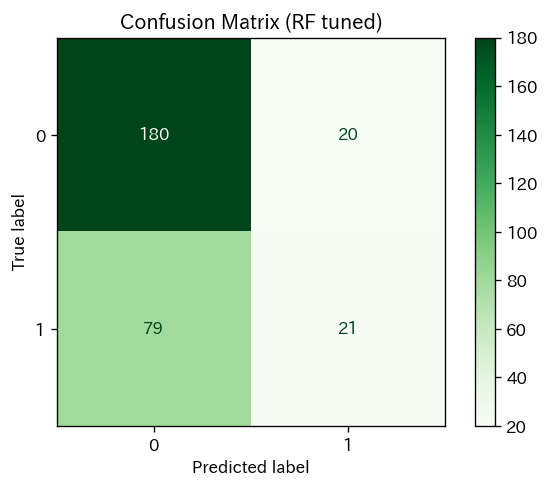

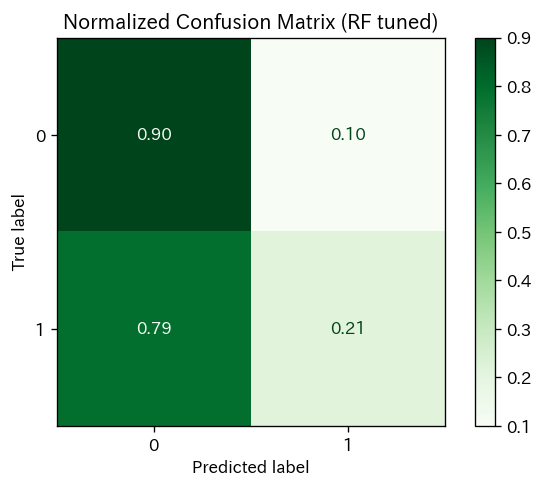

In [202]:
# ==============================================================
# 混同行列（Confusion Matrix）の表示（SVM tuned / RF tuned）
# ==============================================================
# 混同行列は、予測の正解・誤りの内訳を直感的に確認するための指標。
# 4要素：
#   TN: True Negative（正しく失敗と予測）
#   FP: False Positive（誤って成功と予測）→ 誤警報
#   FN: False Negative（誤って失敗と予測）→ 見逃し
#   TP: True Positive（正しく成功と予測）

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- SVM tuned ---
cm_svm_tuned = confusion_matrix(y_test, y_pred_best_svm)
print("Confusion Matrix (SVM tuned):")
print(cm_svm_tuned)

# 混同行列の可視化（件数ベース）
ConfusionMatrixDisplay(confusion_matrix=cm_svm_tuned).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM tuned)")
plt.show()

# 正規化（割合表示）
cmn_svm_tuned = cm_svm_tuned.astype("float") / cm_svm_tuned.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cmn_svm_tuned).plot(values_format=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix (SVM tuned)")
plt.show()


# --- RandomForest tuned ---
cm_rf_tuned = confusion_matrix(y_test, y_pred_best_rf)
print("\nConfusion Matrix (RF tuned):")
print(cm_rf_tuned)

ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned).plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix (RF tuned)")
plt.show()

cmn_rf_tuned = cm_rf_tuned.astype("float") / cm_rf_tuned.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cmn_rf_tuned).plot(values_format=".2f", cmap="Greens")
plt.title("Normalized Confusion Matrix (RF tuned)")
plt.show()


---
## セクション：データ不均衡への対処（クラス重み / SMOTE）

このセクションでは、Markdownで説明していた **不均衡データ対策** をコードで実装します。2つの代表的アプローチを示します。

- **クラス重み（class_weight="balanced"）**：各クラスの頻度に応じて損失を自動補正します。前処理が少なく堅牢です。
- **SMOTE**：少数クラスの近傍サンプルから新規サンプルを合成し、学習データをバランスさせます。  注意：**学習データに対してのみ**適用し、テスト/評価データは元の分布のまま評価します。


In [203]:
# 必要ライブラリ（imbalanced-learn が未インストールな場合は以下を有効化）
# !pip install imbalanced-learn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# SMOTE は imbalanced-learn に含まれます
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    _HAS_IMBLEARN = True
except Exception as e:
    print("imbalanced-learn が読み込めませんでした。SMOTEはスキップします:", e)
    _HAS_IMBLEARN = False

# 既存のデータ変数があるか確認して再利用（なければ簡易に作成 or 分割）
# 期待: X, y が全データ / X_train, X_test, y_train, y_test が分割済み
if 'X' in globals() and 'y' in globals():
    if not all(v in globals() for v in ['X_train','X_test','y_train','y_test']):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
else:
    # フォールバック：合成2値分類データ（講義を自走させるための安全網）
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1200, n_features=10, n_informative=5, n_redundant=2,
                               weights=[0.8, 0.2], flip_y=0.01, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print("Train size:", len(y_train), "Test size:", len(y_test))
unique, counts = np.unique(y_train, return_counts=True)
print("训练ラベル分布:", dict(zip(unique, counts)))

Train size: 900 Test size: 300
训练ラベル分布: {np.int64(0): np.int64(600), np.int64(1): np.int64(300)}


【Class Weight (balanced)】分類レポート
              precision    recall  f1-score   support

           0     0.7263    0.6900    0.7077       200
           1     0.4364    0.4800    0.4571       100

    accuracy                         0.6200       300
   macro avg     0.5813    0.5850    0.5824       300
weighted avg     0.6297    0.6200    0.6242       300

混同行列
[[138  62]
 [ 52  48]]


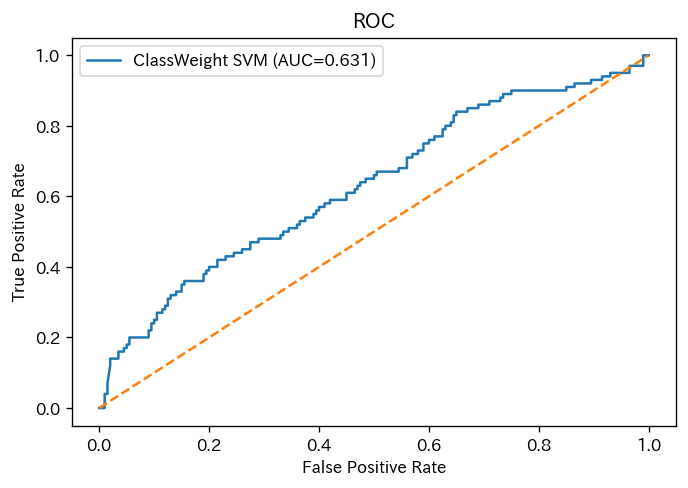

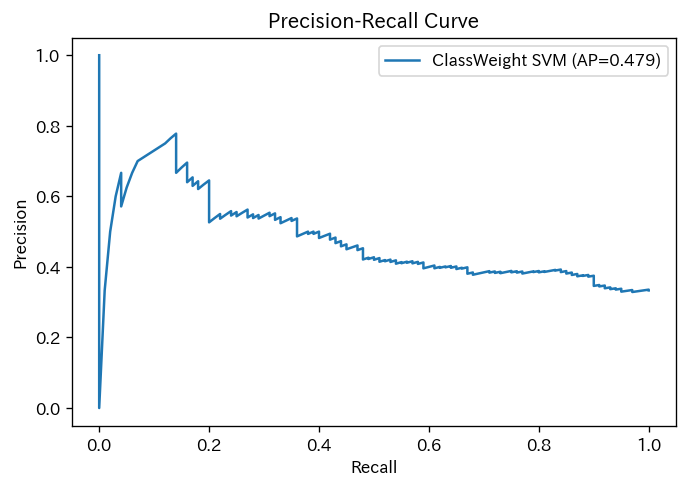

In [204]:
# --- アプローチ1：クラス重み（balanced）を使った SVM ---
svm_balanced = Pipeline([
    ('sc', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])
svm_balanced.fit(X_train, y_train)

y_pred = svm_balanced.predict(X_test)
y_proba = svm_balanced.predict_proba(X_test)[:,1]

print("【Class Weight (balanced)】分類レポート")
print(classification_report(y_test, y_pred, digits=4))

print("混同行列")
print(confusion_matrix(y_test, y_pred))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ClassWeight SVM (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label=f"ClassWeight SVM (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

SMOTE+SVM (CV F1 mean±std): 0.469 ± 0.029

【SMOTE】分類レポート
              precision    recall  f1-score   support

           0     0.7347    0.7200    0.7273       200
           1     0.4615    0.4800    0.4706       100

    accuracy                         0.6400       300
   macro avg     0.5981    0.6000    0.5989       300
weighted avg     0.6436    0.6400    0.6417       300

混同行列
[[144  56]
 [ 52  48]]


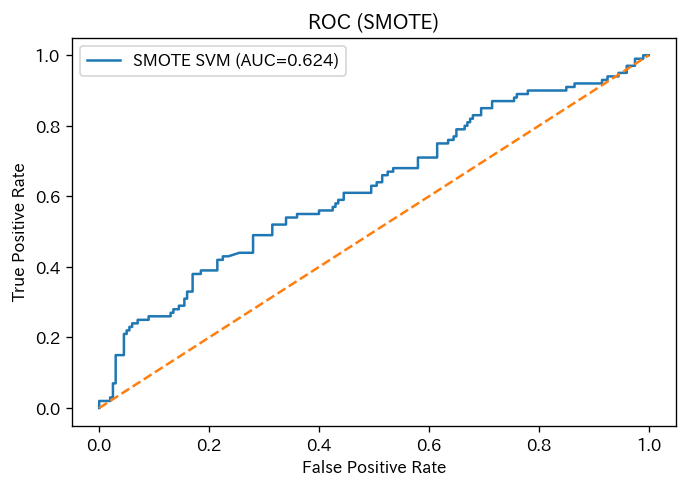

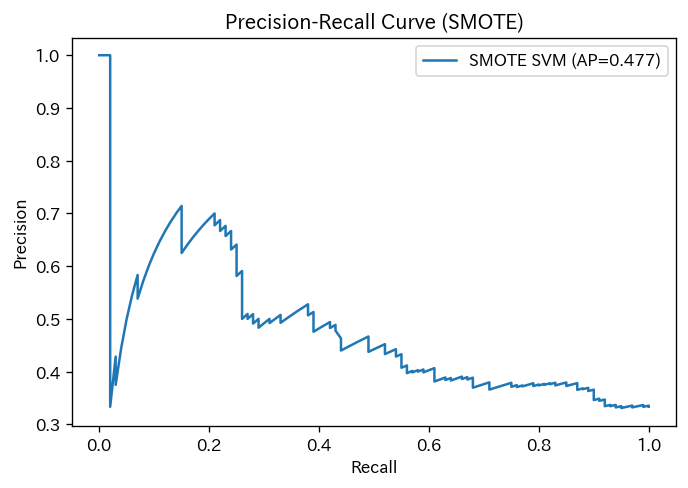

In [205]:
# --- アプローチ2：SMOTE によるオーバーサンプリング ---
if _HAS_IMBLEARN:
    # 交差検証（学習内でのみ SMOTE を適用するパイプライン）
    smote_cv = ImbPipeline([
        ('sm', SMOTE(random_state=42)),
        ('sc', StandardScaler()),
        ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(smote_cv, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    print(f"SMOTE+SVM (CV F1 mean±std): {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

    # テスト評価：学習データにSMOTE、テストは素の分布で評価
    smote_model = ImbPipeline([
        ('sm', SMOTE(random_state=42)),
        ('sc', StandardScaler()),
        ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ])
    smote_model.fit(X_train, y_train)
    y_pred_sm = smote_model.predict(X_test)
    y_proba_sm = smote_model.predict_proba(X_test)[:,1]

    print("\n【SMOTE】分類レポート")
    print(classification_report(y_test, y_pred_sm, digits=4))

    print("混同行列")
    print(confusion_matrix(y_test, y_pred_sm))

    # ROC/PR 可視化
    fpr_sm, tpr_sm, _ = roc_curve(y_test, y_proba_sm)
    roc_auc_sm = auc(fpr_sm, tpr_sm)
    plt.figure()
    plt.plot(fpr_sm, tpr_sm, label=f"SMOTE SVM (AUC={roc_auc_sm:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC (SMOTE)")
    plt.legend()
    plt.show()

    prec_sm, rec_sm, _ = precision_recall_curve(y_test, y_proba_sm)
    ap_sm = average_precision_score(y_test, y_proba_sm)
    plt.figure()
    plt.plot(rec_sm, prec_sm, label=f"SMOTE SVM (AP={ap_sm:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (SMOTE)")
    plt.legend()
    plt.show()
else:
    print("SMOTEはスキップされました（imbalanced-learn が利用不可）。")

---
## セクション：学習曲線（Learning Curve）

データ量に対して学習/汎化性能がどのように変化するかを可視化します。**過学習/未学習の診断**や、**追加データの価値**の見積もりに有用です。


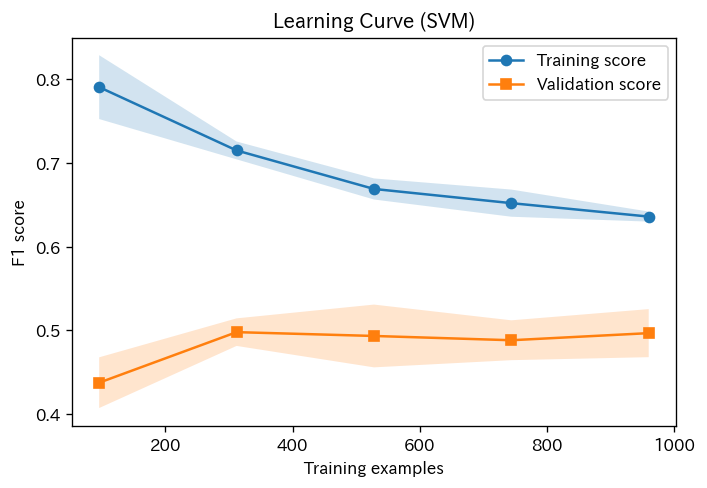

In [206]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# 学習曲線に用いる推定器：既に作成した svm_balanced があれば使う、なければ標準パイプラインを作る
if 'svm_balanced' in globals():
    estimator = svm_balanced
else:
    estimator = Pipeline([
        ('sc', StandardScaler()),
        ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ])

if 'X' in globals() and 'y' in globals():
    X_lc, y_lc = X, y
else:
    X_lc, y_lc = X_train, y_train

train_sizes, train_scores, val_scores = learning_curve(
    estimator=estimator,
    X=X_lc, y=y_lc,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5, scoring="f1", n_jobs=-1, shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Training score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, marker="s", label="Validation score")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training examples")
plt.ylabel("F1 score")
plt.title("Learning Curve (SVM)")
plt.legend()
plt.show()

---
## セクション：SVM tuned 後の混同行列（修正）

先のセルでは **SVM tuned** の混同行列を表示するはずが、図としては **RF tuned** の行列を再表示していました（コピペ由来の指標ラベル/変数指定ミス）。  
ここで **SVM tuned** の `y_pred_best_svm` / `y_proba_best_svm` を明示的に作り直し、**SVM/RF** それぞれの混同行列を正しく描画します。


[SVM tuned on Test]
              precision    recall  f1-score   support

           0      0.695     0.925     0.794       200
           1      0.559     0.190     0.284       100

    accuracy                          0.680       300
   macro avg      0.627     0.557     0.539       300
weighted avg      0.650     0.680     0.624       300



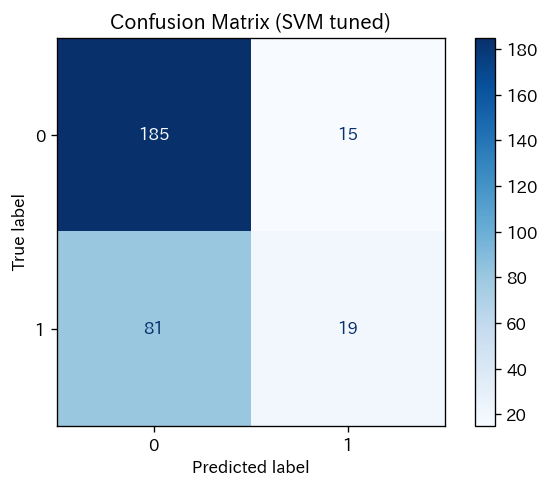

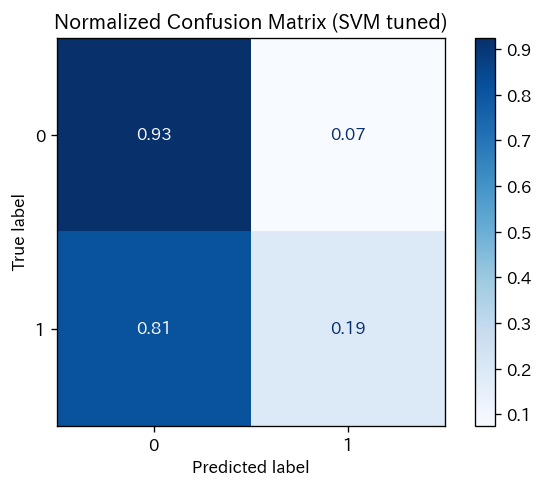

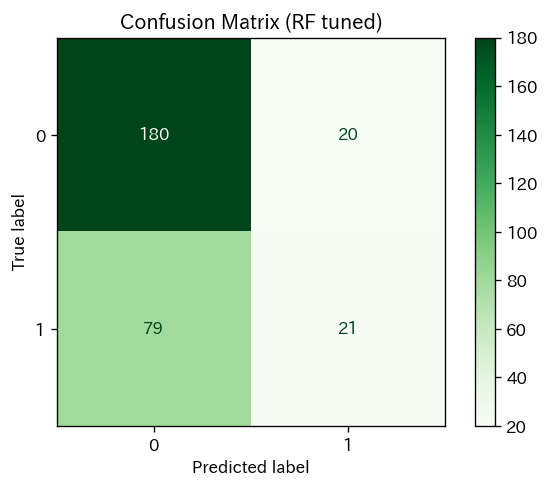

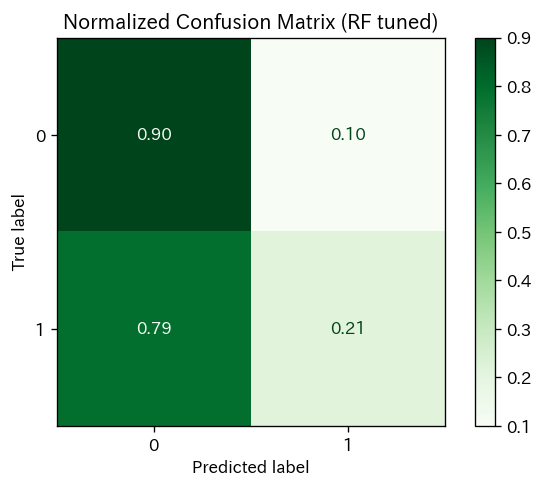

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure tuned SVM exists ---
if 'best_svm' not in globals() or 'y_pred_best_svm' not in globals():
    param_grid_svm = {
        'svc__C': [0.1, 1, 3, 10],
        'svc__gamma': ['scale', 0.1, 0.03, 0.01]
    }
    pipe_svm = Pipeline([('sc', StandardScaler()), ('svc', SVC(kernel='rbf', probability=True, random_state=42))])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_svm = GridSearchCV(pipe_svm, param_grid_svm, scoring='f1', cv=cv, n_jobs=-1)
    grid_svm.fit(X_train, y_train)
    best_svm = grid_svm.best_estimator_

y_pred_best_svm = best_svm.predict(X_test)
y_proba_best_svm = best_svm.predict_proba(X_test)[:,1]

print("[SVM tuned on Test]")
print(classification_report(y_test, y_pred_best_svm, digits=3))

# --- SVM tuned Confusion Matrix ---
cm_svm_tuned = confusion_matrix(y_test, y_pred_best_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_svm_tuned).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM tuned)")
plt.show()

cmn_svm_tuned = cm_svm_tuned.astype(float) / cm_svm_tuned.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(confusion_matrix=cmn_svm_tuned).plot(values_format=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix (SVM tuned)")
plt.show()

# --- RF tuned Confusion Matrix (only if available) ---
if 'y_pred_best_rf' in globals():
    cm_rf_tuned = confusion_matrix(y_test, y_pred_best_rf)
    ConfusionMatrixDisplay(confusion_matrix=cm_rf_tuned).plot(cmap="Greens", values_format="d")
    plt.title("Confusion Matrix (RF tuned)")
    plt.show()

    cmn_rf_tuned = cm_rf_tuned.astype(float) / cm_rf_tuned.sum(axis=1, keepdims=True)
    ConfusionMatrixDisplay(confusion_matrix=cmn_rf_tuned).plot(values_format=".2f", cmap="Greens")
    plt.title("Normalized Confusion Matrix (RF tuned)")
    plt.show()
else:
    print("注意: y_pred_best_rf が見つかりませんでした。RF tuned の表示はスキップします。")